# 4. Preprocessing and training

## 4.1. Preparation

### 4.1.1. Import os and modules

In [1]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.cm as cm
import seaborn as sns
import sklearn
import json
from sklearn import __version__ as sklearn_version
from sklearn.preprocessing import scale, StandardScaler, normalize, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve, ParameterGrid
from sklearn.dummy import DummyRegressor
from sklearn.cluster import KMeans, OPTICS, cluster_optics_dbscan, AgglomerativeClustering, DBSCAN
from sklearn import mixture
from sklearn import metrics
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score, adjusted_rand_score, silhouette_samples, make_scorer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
import datetime
from clusteval import clusteval
from yellowbrick.target import FeatureCorrelation
import scipy.cluster.hierarchy as shc
from scipy.spatial import distance_matrix
from operator import itemgetter
import matplotlib.patches as mpatches 
from kneed import KneeLocator

In [3]:
import warnings
warnings.filterwarnings("ignore")

### 4.1.2. Read in data

In [4]:
market=pd.read_csv(r"C:\Users\crathgeb-pc\Desktop\jup_ntb\capstone_3\market.csv", index_col=0)
market.head()

,Year_Birth,Education,Marital_Status,Income,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,...,web_purchases,cat_purchases,in_store_purchases,NumWebVisitsMonth,Complain,children,accepted_offer,total_purchases,enroll_yr,total_spent
0,1957,College,Single,58138.0,58,635,88,546,172,88,...,8,10,4,7,0,0,1,22,2012,1617
1,1954,College,Single,46344.0,38,11,1,6,2,1,...,1,1,2,5,0,2,0,4,2014,27
2,1965,College,Coupled,71613.0,26,426,49,127,111,21,...,8,2,10,4,0,0,0,20,2013,776
3,1984,College,Coupled,26646.0,26,11,4,20,10,3,...,2,0,4,6,0,1,0,6,2014,53
4,1981,PhD,Married,58293.0,94,173,43,118,46,27,...,5,3,6,5,0,1,0,14,2014,422


In [5]:
market = pd.get_dummies(market)

In [6]:
market.shape

(2235, 27)

In [7]:
market.isna().sum()

Year_Birth                0
Income                    0
Recency                   0
MntWines                  0
MntFruits                 0
MntMeatProducts           0
MntFishProducts           0
MntSweetProducts          0
MntGoldProds              0
NumDealsPurchases         0
web_purchases             0
cat_purchases             0
in_store_purchases        0
NumWebVisitsMonth         0
Complain                  0
children                  0
accepted_offer            0
total_purchases           0
enroll_yr                 0
total_spent               0
Education_College         0
Education_High_school     0
Education_Masters         0
Education_PhD             0
Marital_Status_Coupled    0
Marital_Status_Married    0
Marital_Status_Single     0
dtype: int64

## 4.2. Initial models

### 4.2.1. Impute missing values

During data wrangling, we saw that the distribution for many of our variables is quite skewed.  Therefore, it makes more sense to impute missing values with the median value for each column rather than the mean.

In [8]:
defaults_median = market.median()
defaults_median

mark_med = market.fillna(defaults_median)

### 4.2.2. Scale data

In [9]:
scaler = StandardScaler()
scaler.fit(mark_med)
mark_med = scaler.transform(mark_med)

### 4.3.1. K-means

4.3.1.1. Using basic pipeline

In [10]:
pipe_kmeans = Pipeline(
    [("Impute", SimpleImputer(strategy='median')), 
     ("Scale", StandardScaler()), 
     ("KMeans", KMeans())])

pipe_kmeans.fit(market)

pred_k = pipe_kmeans.predict(market)

Text(0.5, 1.0, 'Labeled Customer Data')

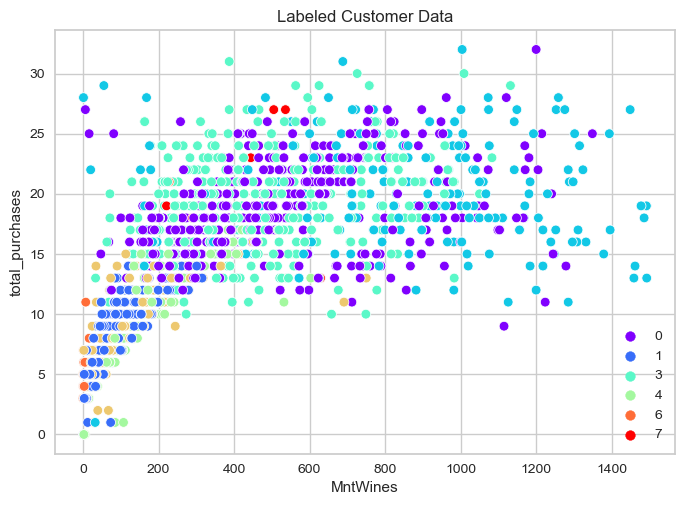

In [11]:
sns.scatterplot(x='MntWines', 
                y='total_purchases', 
                data=market, 
                hue=pred_k,
                palette="rainbow").set_title('Labeled Customer Data')

Text(0.5, 1.0, 'Labeled Customer Data')

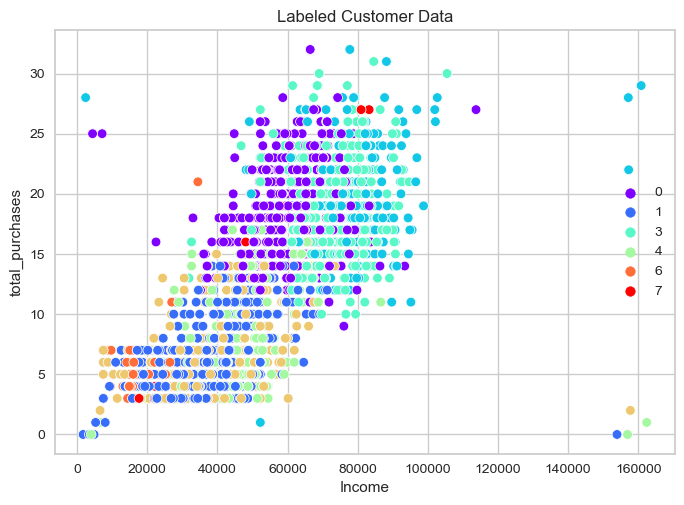

In [12]:
sns.scatterplot(x='Income', 
                y='total_purchases', 
                data=market, 
                hue=pred_k,
                palette="rainbow").set_title('Labeled Customer Data')

In [13]:
cluster_map = pd.DataFrame()
cluster_map['data_index'] = market.index.values
cluster_map['k_cluster'] = pred_k

In [14]:
cluster_map['k_cluster'].nunique()

8

In [15]:
cluster_map[cluster_map.k_cluster == 1]

,data_index,k_cluster
1,1,1
3,3,1
10,10,1
14,14,1
16,16,1
...,...,...
2214,2218,1
2225,2229,1
2226,2230,1
2228,2232,1


### 4.3.2. OPTICS

In [16]:
imputer = SimpleImputer(strategy='median')
imputer.fit(market)
trans = imputer.transform(market)

scaler = StandardScaler()
scaler.fit(trans)
scaled_data = scaler.transform(trans)

mod_opt = OPTICS()

mod_opt.fit(scaled_data)

pred_opt = mod_opt.labels_

In [17]:
cluster_map['opt_cluster'] = pred_opt

In [18]:
cluster_map['opt_cluster'].nunique()

38

Text(0.5, 1.0, 'Labeled Customer Data')

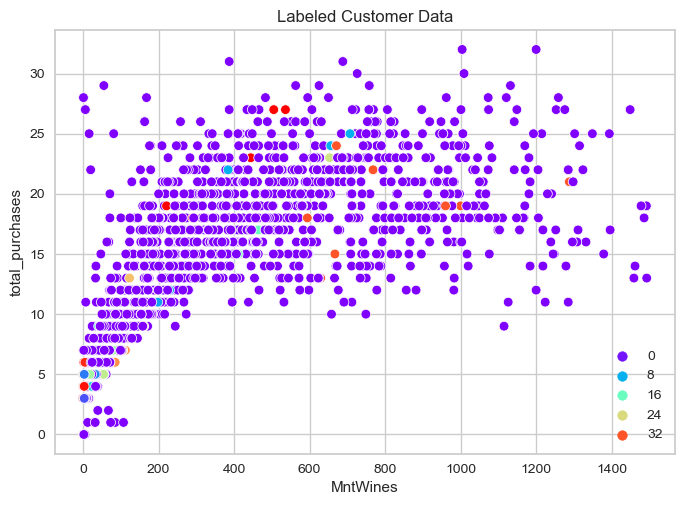

In [19]:
sns.scatterplot(x='MntWines', 
                y='total_purchases', 
                data=market, 
                hue=pred_opt,
                palette="rainbow").set_title('Labeled Customer Data')

Text(0.5, 1.0, 'Labeled Customer Data')

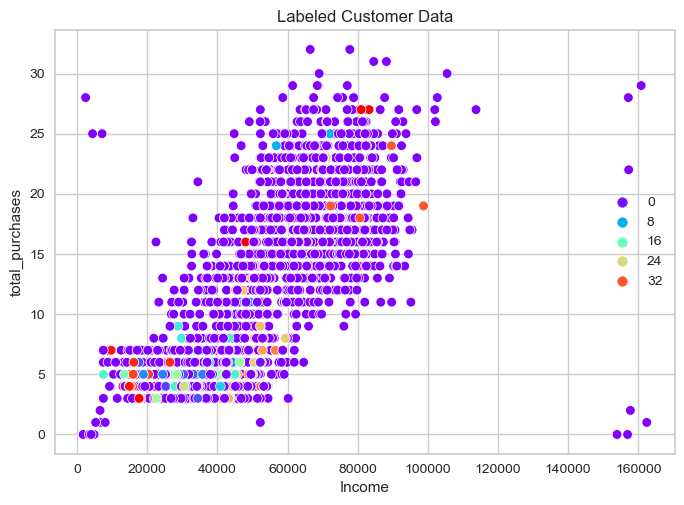

In [20]:
sns.scatterplot(x='Income', 
                y='total_purchases', 
                data=market, 
                hue=pred_opt,
                palette="rainbow").set_title('Labeled Customer Data')

### 4.3.3. Agglomerative Hierarchical Clustering

In [21]:
mod_agg = AgglomerativeClustering()

mod_agg.fit(scaled_data)

pred_agg = mod_agg.labels_

In [22]:
cluster_map['agg_cluster'] = pred_agg

In [23]:
cluster_map['agg_cluster'].nunique()

2

Text(0.5, 1.0, 'Labeled Customer Data')

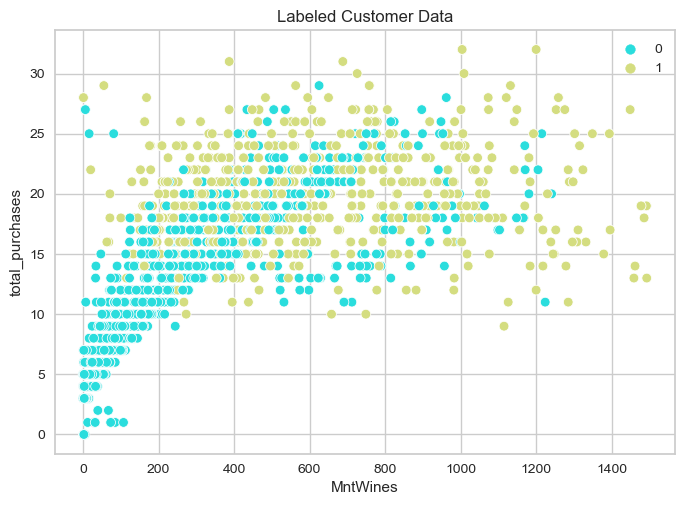

In [24]:
sns.scatterplot(x='MntWines', 
                y='total_purchases', 
                data=market, 
                hue=pred_agg,
                palette="rainbow").set_title('Labeled Customer Data')

Text(0.5, 1.0, 'Labeled Customer Data')

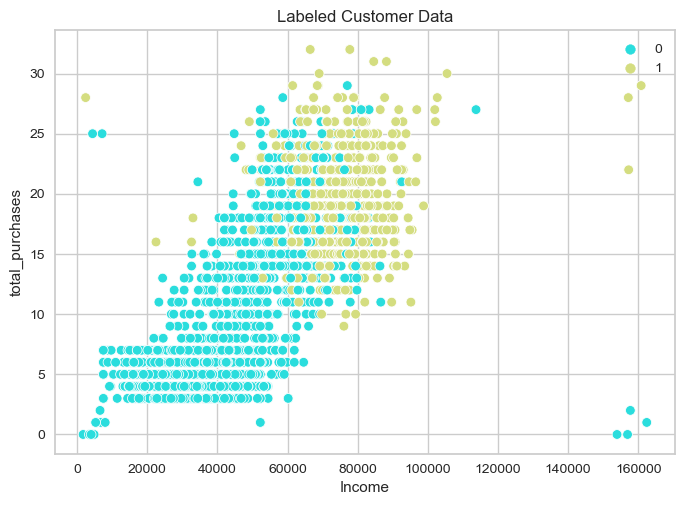

In [25]:
sns.scatterplot(x='Income', 
                y='total_purchases', 
                data=market, 
                hue=pred_agg,
                palette="rainbow").set_title('Labeled Customer Data')

### 4.3.4. Gaussian Mixture Model

In [26]:
pipe_gmm = Pipeline(
    [("Impute", SimpleImputer(strategy='median')), 
     ("Scale", StandardScaler()), 
     ("GMM", mixture.GaussianMixture())])

pipe_gmm.fit(market)

pred_gmm = pipe_gmm.predict(market)

In [27]:
cluster_map['gmm_cluster'] = pred_gmm

In [28]:
cluster_map['gmm_cluster'].nunique()

1

Without defining a number of clusters, the basic pipeline for KMeans resulted in 8 clusters, Optics in 142, 45 clusters, hierarchical (agglomerative) in 2, and Gaussian mixture in 1.  As one group of customers would not be useful for the company, I refined the Gaussian mixture model using various to find a baseline for this model before adjusting and comparing all the models.

In [29]:
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV


def bic_score(estimator, X):
    """Callable to pass to GridSearchCV that will use the BIC score."""
    # Make it negative since GridSearchCV expects a score to maximize
    return -estimator.bic(X)


param_grid = {
    "n_components": range(1, 7),
    "covariance_type": ["spherical", "tied", "diag", "full"],
}
grid_search = GridSearchCV(
    GaussianMixture(), param_grid=param_grid, scoring=bic_score
)

grid_search.fit(market)

GridSearchCV(estimator=GaussianMixture(),
             param_grid={'covariance_type': ['spherical', 'tied', 'diag',
                                             'full'],
                         'n_components': range(1, 7)},
             scoring=<function bic_score at 0x00000262488C5E50>)

In [30]:
df = pd.DataFrame(grid_search.cv_results_)[
    ["param_n_components", "param_covariance_type", "mean_test_score"]
]
df["mean_test_score"] = -df["mean_test_score"]
df = df.rename(
    columns={
        "param_n_components": "Number of components",
        "param_covariance_type": "Type of covariance",
        "mean_test_score": "BIC score",
    }
)
df.sort_values(by="BIC score").head()

,Number of components,Type of covariance,BIC score
19,2,full,39124.429549
11,6,tied,39140.843740
20,3,full,39987.499790
10,5,tied,40245.009742
22,5,full,40636.121322


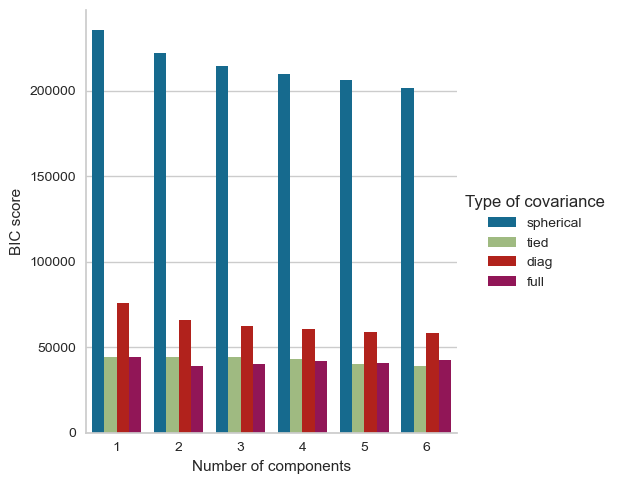

In [31]:
sns.catplot(
    data=df,
    kind="bar",
    x="Number of components",
    y="BIC score",
    hue="Type of covariance",
)
plt.show()

The model with 2 components and full covariance has the lowest BIC score.  Therefore, I will use these hyperparameters for the initial GMM model.

In [32]:
pipe_gmm = Pipeline(
    [("Impute", SimpleImputer(strategy='median')), 
     ("Scale", StandardScaler()), 
     ("GMM", mixture.GaussianMixture(n_components=2, covariance_type='full'))])

pipe_gmm.fit(market)

pred_gmm = pipe_gmm.predict(market)

In [33]:
cluster_map['gmm_cluster'] = pred_gmm

Text(0.5, 1.0, 'Labeled Customer Data')

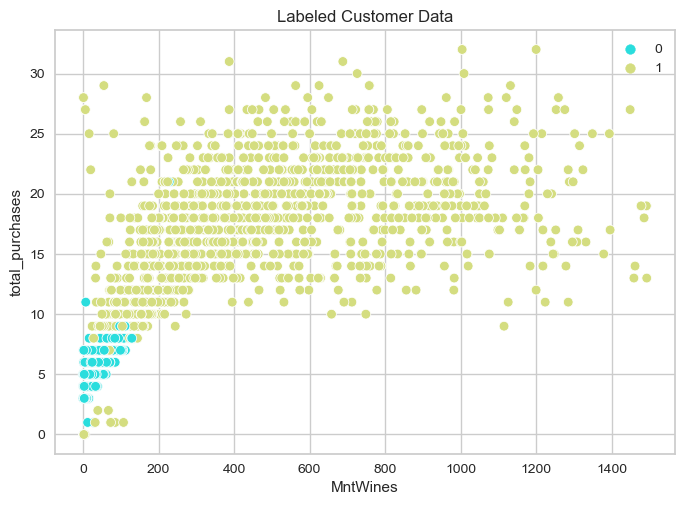

In [34]:
sns.scatterplot(x='MntWines', 
                y='total_purchases', 
                data=market, 
                hue=pred_gmm,
                palette="rainbow").set_title('Labeled Customer Data')

Text(0.5, 1.0, 'Labeled Customer Data')

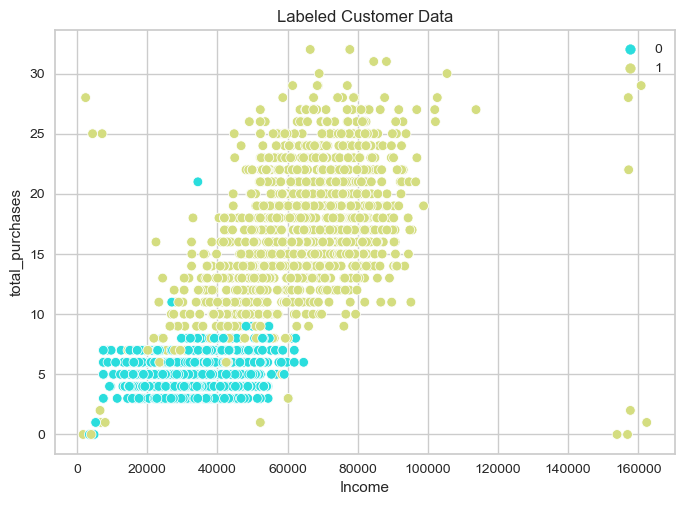

In [35]:
sns.scatterplot(x='Income', 
                y='total_purchases', 
                data=market, 
                hue=pred_gmm,
                palette="rainbow").set_title('Labeled Customer Data')

In [36]:
cluster_map.nunique()

data_index     2235
k_cluster         8
opt_cluster      38
agg_cluster       2
gmm_cluster       2
dtype: int64

## 4.3. Refine models

### 4.3.1. Best number of clusters

4.3.1.1. Elbow method

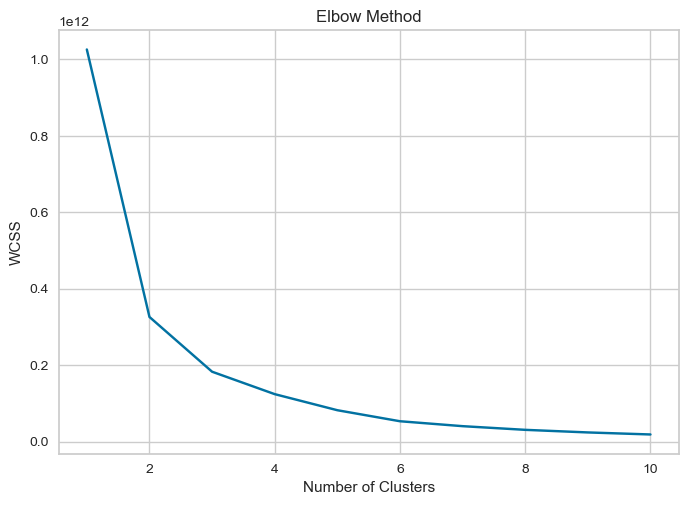

In [37]:
X = market

# use elbow mwthod to find optimal number of clusters
from sklearn.cluster import KMeans

# with in cluster sum of squares
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters =i, init="k-means++", max_iter=300, n_init=10)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss);
plt.title("Elbow Method")
plt.xlabel("Number of Clusters")
plt.ylabel("WCSS")
plt.show()

The elbow method indicates that the best number of clusters would be 2 or 3.  I will also examine the silhouette score to see whether it indicates similar or differing numbers.

4.3.1.2. Silhouette score

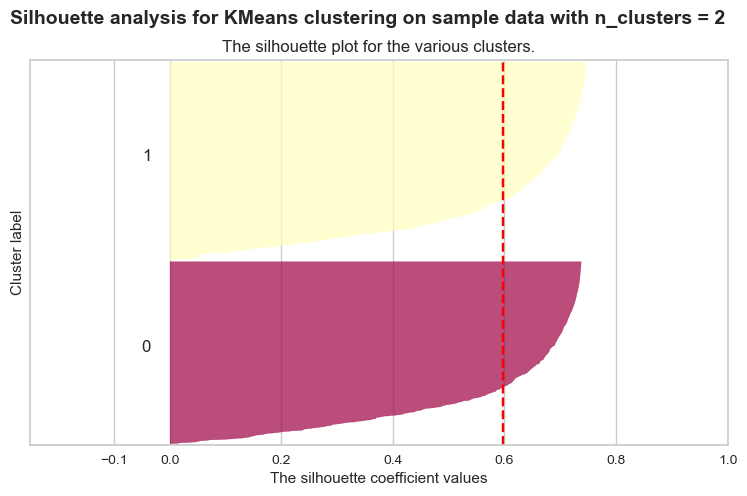

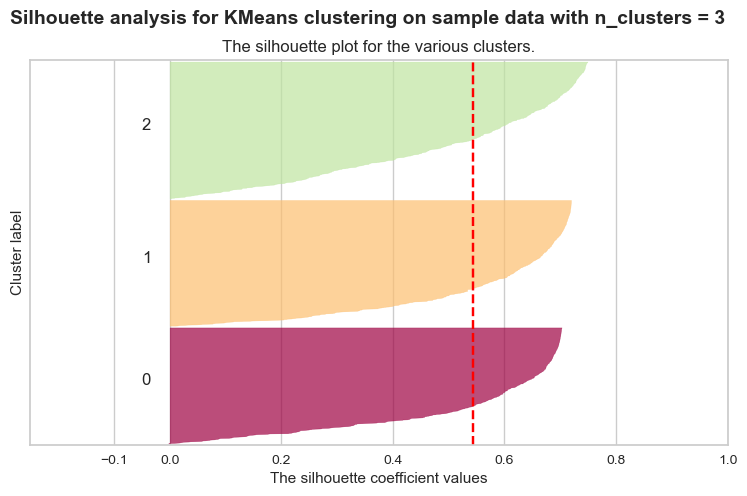

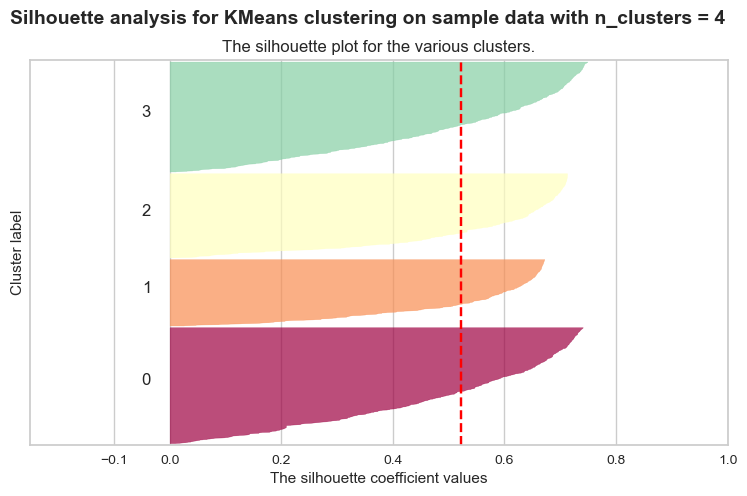

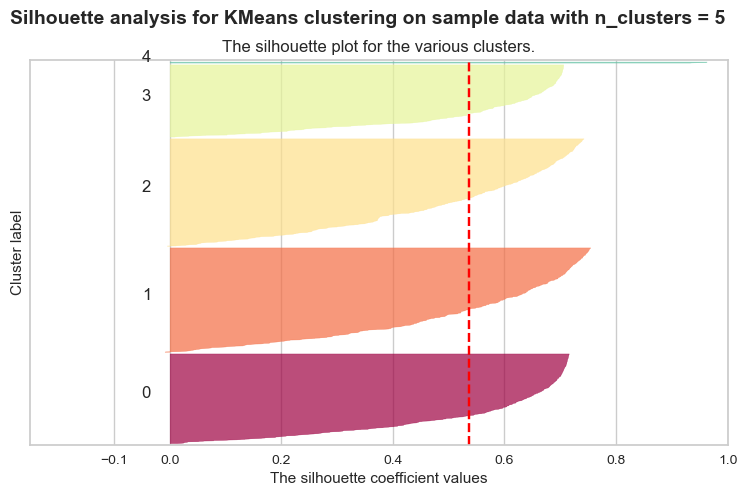

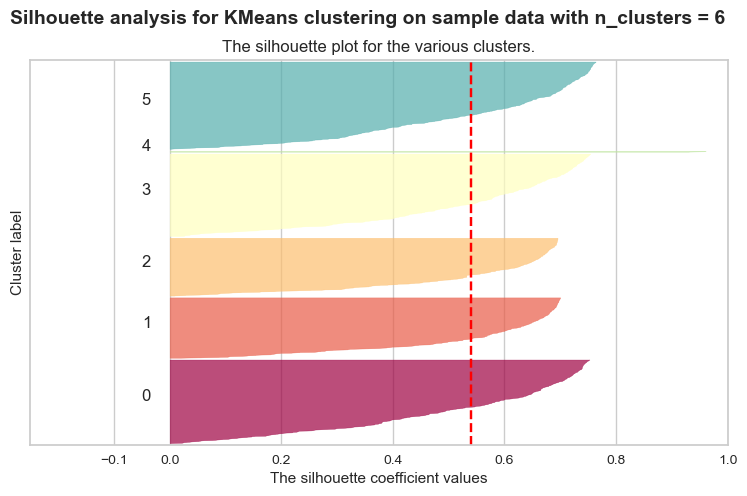

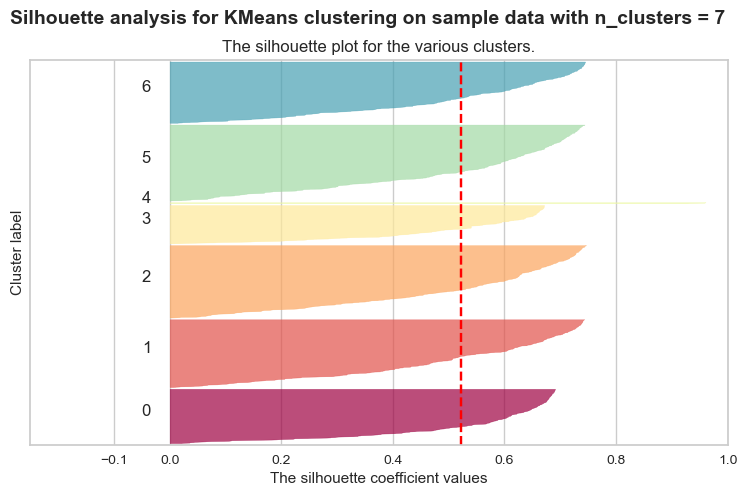

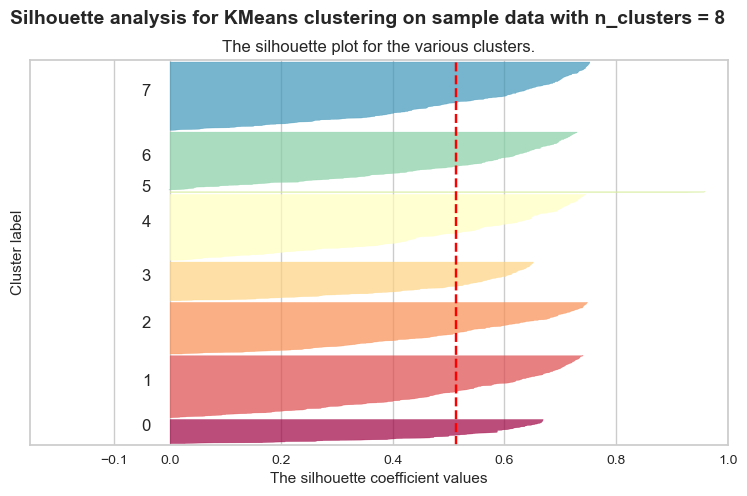

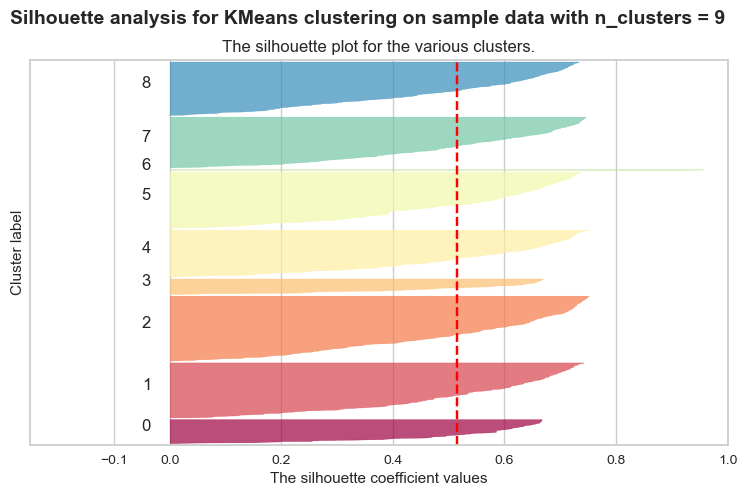

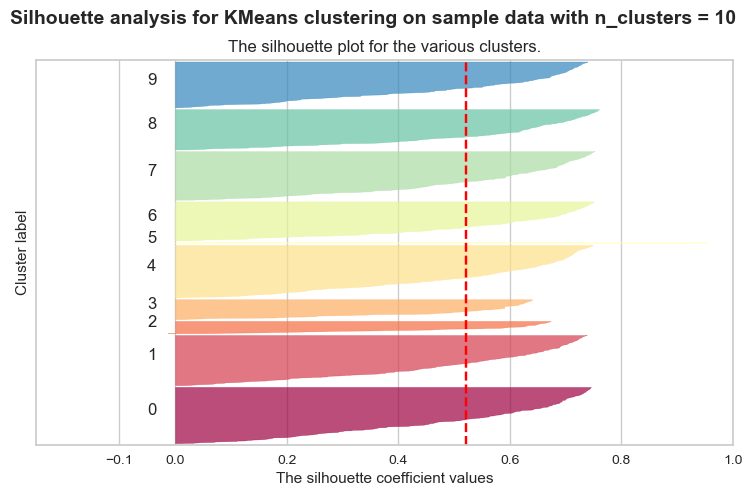

In [38]:
avg_silhouette_scores = []

Krange  = list(range(2, 11))

# Iterate through Krange with variable K as before
for K in Krange:
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(9, 5)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    # Call set_xlim on ax1 
    ax1.set_xlim([-0.25, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (K + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=K, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    # Make a variable called silhouette_avg. Set the parameters to silhouette_score to X, and cluster_labels
    silhouette_avg  = silhouette_score(X, cluster_labels)
    avg_silhouette_scores.append(silhouette_avg)

    # Compute the silhouette scores for each sample
    # Call sklearn.metrics.silhouette_samples with the below parameters
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(K):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        # Make a variable called ith_cluster_silhouette_values
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        # Call sort() on this variable 
        ith_cluster_silhouette_values.sort()
    
        # Call shape[0] on ith_cluster_silhouette_values 
        size_cluster_i = ith_cluster_silhouette_values.shape[0] 
        y_upper = y_lower + size_cluster_i

        cmap = cm.get_cmap("Spectral")
        color = cmap(float(i) / K)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        # This requires calling text() on ax1 
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    # Setting title, xlabel and ylabel 
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    # This requires axvline() 
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % K),
                 fontsize=14, fontweight='bold')

Text(0, 0.5, 'Average Silhouette Score')

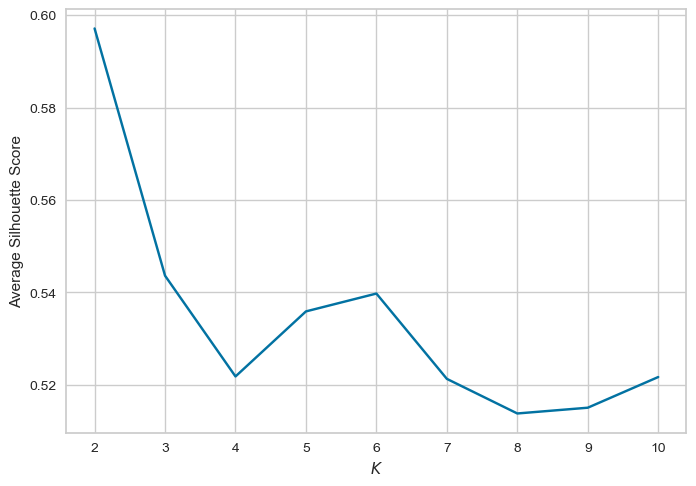

In [39]:
plt.plot(Krange, avg_silhouette_scores)
plt.xlabel("$K$")
plt.ylabel("Average Silhouette Score")

Using the elbow method, 2 or 3 appear to be the ideal number of clusters.  The silhouette method suggests 2, 3, and 6 seem to be reasonably good options.  After completing research using 3 clusters with the following models, I found that there was less distinction between attributes of the customers in each group than I had hoped to see or believed useful for business decisions.  Therefore, I repeated the analysis using k=2 instead.  

According to the silhouette score, the best k values are 2, 3, or 6.  2 results in the highest silhouette score.   While having 3 or 6 clusters could be useful for some business decisions, it also may divide customers more than is useful.  As the elbow method also suggested that 2 was an ideal number of clusters, I will proceed in developing a method for dividing customers into 2 clusters.

### 4.3.2. Finding best distance between points

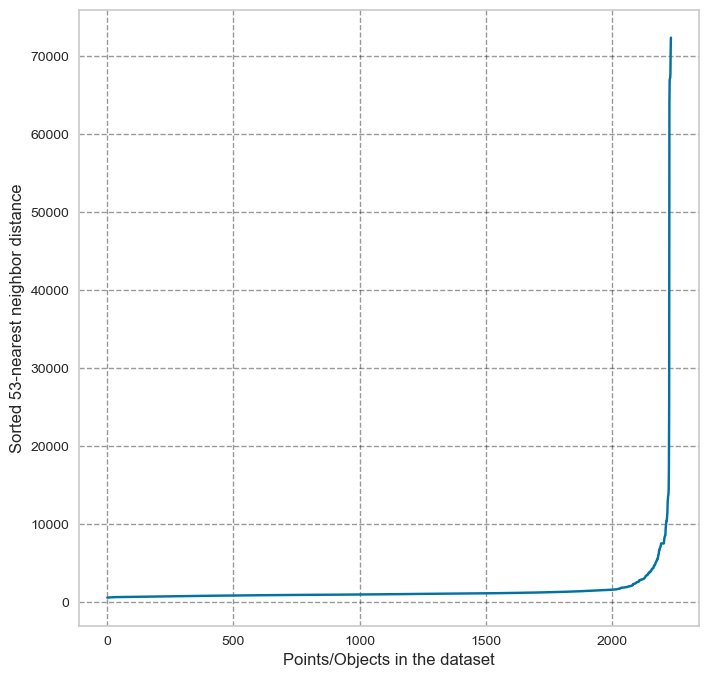

In [40]:
from sklearn.neighbors import NearestNeighbors


def get_kdist_plot(X=None, k=None, radius_nbrs=1.0):

    nbrs = NearestNeighbors(n_neighbors=k, radius=radius_nbrs).fit(market)

    # For each point, compute distances to its k-nearest neighbors
    distances, indices = nbrs.kneighbors(market) 
                                       
    distances = np.sort(distances, axis=0)
    distances = distances[:, k-1]

    # Plot the sorted K-nearest neighbor distance for each point in the dataset
    plt.figure(figsize=(8,8))
    plt.plot(distances)
    plt.xlabel('Points/Objects in the dataset', fontsize=12)
    plt.ylabel('Sorted {}-nearest neighbor distance'.format(k), fontsize=12)
    plt.grid(True, linestyle="--", color='black', alpha=0.4)
    plt.show()
    plt.close()


k = 2 * X.shape[-1] - 1 # k=2*{dim(dataset)} - 1
get_kdist_plot(X=market, k=k)

This shows that the best k distance appears to be between about 500 and 6000.  This is a wide range.  Perhaps restricting the graph will allow us to "zoom in" and get a closer estimate for best k distance.

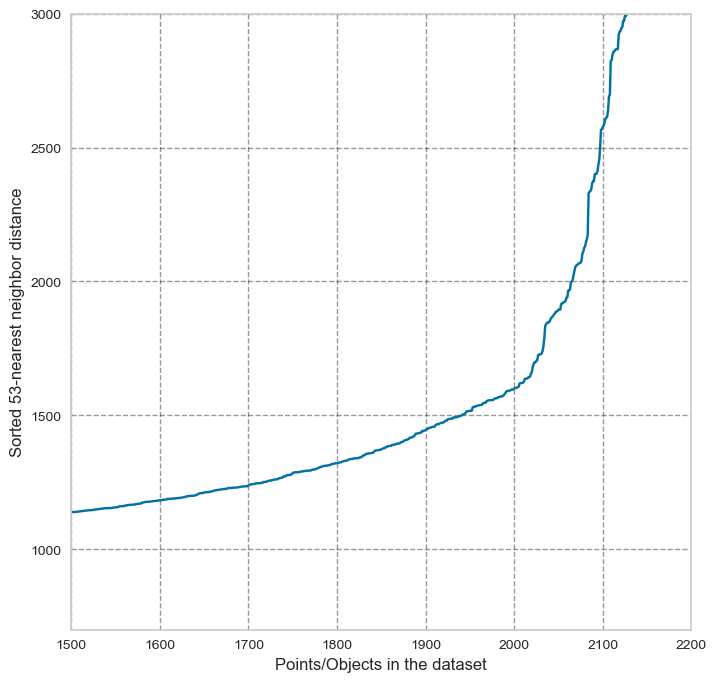

In [41]:
def zoomed_kdist_plot(X=None, k=None, radius_nbrs=1.0):

    nbrs = NearestNeighbors(n_neighbors=k, radius=radius_nbrs).fit(market)

    # For each point, compute distances to its k-nearest neighbors
    distances, indices = nbrs.kneighbors(market) 
                                       
    distances = np.sort(distances, axis=0)
    distances = distances[:, k-1]

    # Plot the sorted K-nearest neighbor distance for each point in the dataset
    plt.figure(figsize=(8,8))
    plt.plot(distances)
    plt.xlabel('Points/Objects in the dataset', fontsize=12)
    plt.ylabel('Sorted {}-nearest neighbor distance'.format(k), fontsize=12)
    plt.grid(True, linestyle="--", color='black', alpha=0.4)
    plt.xlim(1500, 2200)
    plt.ylim(700, 3000)
    plt.show()
    plt.close()


k = 2 * X.shape[-1] - 1 # k=2*{dim(dataset)} - 1
zoomed_kdist_plot(X=market, k=k)

This helps us narrow the range of the best kdistance to between 1200 to 1600.  If I were choosing a single value, I would choose about 1400, however, I will examine various values in this range to determine which performs best in the model.

### 4.3.2. Finding best hyperparameters for each model

We already established the best hyperparameters for our GMM model to fix the problem of the default model creating only one cluster.  We will now establish the best hyperparameters for each of the other models.

*** Because of the way the optics algorithm works, tuning hyperparameters is less useful and has less of an impact than for other algorithms.

A general guideline for Optics's minimum samples hyperparameter optimal value is that it should be set to twice the number of features.  The number of features is 18, which, by this guideline, makes the optimum number of minimum samples 36.  

Choosing epsilon is the most important choice of hyperparameters for DBSCAN.  This is the maximum distance between two points in a cluster.  A K-distance plot can help point to values that may be best for this distance.  The "knee" of the plot shows where distances between points of our dataframe begin to see a distinct jump from closer points to those that are far relative to other points.  This gives a reasonably good indication of the maximum distance we may want between points in one cluster. 

In [50]:
imputer = SimpleImputer(strategy='median')
new = imputer.fit_transform(market)
scaler = StandardScaler()
data = scaler.fit_transform(new)

params = {'n_clusters':[2, 3, 5, 6], 
          'metric':['cosine', 'euclidean', 'manhattan'], 
          'linkage':['average', 'complete', 'single']} 

grid = sklearn.model_selection.ParameterGrid(params)
d = {'sil_score': [], 'params': []}

for param in grid:
    agg = AgglomerativeClustering(**param, compute_distances=True)
    agg.fit(data)
    labels=agg.fit_predict(data)
    d['sil_score'].append(silhouette_score(data, labels))
    d['params'].append(param)
    
df = pd.DataFrame((d), columns = (['sil_score', 'params']))

In [51]:
agg_params=df.sort_values(by='sil_score', ascending=False, ignore_index=True)

In [52]:
agg_params

,sil_score,params
0,0.522831,"{'linkage': 'complete', 'metric': 'euclidean',..."
1,0.522831,"{'linkage': 'average', 'metric': 'euclidean', ..."
2,0.522831,"{'linkage': 'average', 'metric': 'manhattan', ..."
3,0.522831,"{'linkage': 'single', 'metric': 'manhattan', '..."
4,0.473830,"{'linkage': 'single', 'metric': 'manhattan', '..."
5,0.473830,"{'linkage': 'average', 'metric': 'manhattan', ..."
6,0.446398,"{'linkage': 'single', 'metric': 'cosine', 'n_c..."
7,0.446398,"{'linkage': 'single', 'metric': 'euclidean', '..."
8,0.445870,"{'linkage': 'average', 'metric': 'euclidean', ..."
9,0.445870,"{'linkage': 'single', 'metric': 'euclidean', '..."


In [53]:
agg_params.join(pd.DataFrame(agg_params.pop('params').values.tolist()))

,sil_score,linkage,metric,n_clusters
0,0.522831,complete,euclidean,2
1,0.522831,average,euclidean,2
2,0.522831,average,manhattan,2
3,0.522831,single,manhattan,2
4,0.473830,single,manhattan,3
5,0.473830,average,manhattan,3
6,0.446398,single,cosine,2
7,0.446398,single,euclidean,2
8,0.445870,average,euclidean,3
9,0.445870,single,euclidean,3


In [55]:
imputer = SimpleImputer(strategy='median')
new = imputer.fit_transform(market)
scaler = StandardScaler()
data = scaler.fit_transform(new)

params = {'distance_threshold':[0.01, 0.1, 1, 10, 100]} 

grid = sklearn.model_selection.ParameterGrid(params)
d = {'sil_score': [], 'params': []}

for param in grid:
    agg = AgglomerativeClustering(**param, compute_distances=True, compute_full_tree=True, n_clusters=None)
    agg.fit(data)
    d['sil_score'].append(silhouette_score(market, agg.fit_predict(data)))
    d['params'].append(param)
    
df = pd.DataFrame((d), columns = (['sil_score', 'params']))

In [56]:
agg_params=df.sort_values(by='sil_score', ascending=False, ignore_index=True)

In [57]:
agg_params.join(pd.DataFrame(agg_params.pop('params').values.tolist()))

,sil_score,distance_threshold
0,0.397729,100.00
1,0.161969,0.01
2,0.161969,0.10
3,0.091131,1.00
4,-0.547793,10.00


In [71]:
imputer = SimpleImputer(strategy='median')
new = imputer.fit_transform(market)
scaler = StandardScaler()
data = scaler.fit_transform(new)

params = {'distance_threshold':[1.5, 2, 3, 4, 5]} 

grid = sklearn.model_selection.ParameterGrid(params)
d = {'sil_score': [], 'params': []}

for param in grid:
    agg = AgglomerativeClustering(**param, compute_distances=True, compute_full_tree=True, n_clusters=None)
    agg.fit(data)
    d['sil_score'].append(silhouette_score(data, agg.fit_predict(data)))
    d['params'].append(param)
    
df = pd.DataFrame((d), columns = (['sil_score', 'params']))

In [72]:
agg_params=df.sort_values(by='sil_score', ascending=False, ignore_index=True)

In [73]:
agg_params.join(pd.DataFrame(agg_params.pop('params').values.tolist()))

,sil_score,distance_threshold
0,0.220861,3.0
1,0.220000,2.0
2,0.210898,4.0
3,0.208054,1.5
4,0.187554,5.0


In [61]:
imputer = SimpleImputer(strategy='median')
new = imputer.fit_transform(market)
scaler = StandardScaler()
data = scaler.fit_transform(new)

params = {'eps':[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'p': [1, 2]} 

grid = sklearn.model_selection.ParameterGrid(params)
d = {'sil_score': [], 'params': []}

for param in grid:
    db = DBSCAN(**param, min_samples=2)
    db.fit(data)
    d['sil_score'].append(silhouette_score(data, db.labels_))
    d['params'].append(param)
    
db_df = pd.DataFrame((d), columns = (['sil_score', 'params']))

In [62]:
db_params=db_df.sort_values(by='sil_score', ascending=False, ignore_index=True)

In [63]:
db_params.join(pd.DataFrame(db_params.pop('params').values.tolist()))

,sil_score,eps,p
0,0.446398,10,2
1,0.446398,10,1
2,0.443647,8,2
3,0.443647,8,1
4,0.438544,9,2
5,0.438544,9,1
6,0.393535,7,2
7,0.393535,7,1
8,0.266718,6,2
9,0.266718,6,1


In [64]:
imputer = SimpleImputer(strategy='median')
new = imputer.fit_transform(market)
scaler = StandardScaler()
data = scaler.fit_transform(new)

params = {'n_clusters':[2, 3, 5, 6], 
          'algorithm':['lloyd', 'elkan']} 

grid = sklearn.model_selection.ParameterGrid(params)
k = {'sil_score': [], 'params': []}

for param in grid:
    km = KMeans(**param, n_init=20)
    km.fit(data)
    k['sil_score'].append(silhouette_score(market, km.fit_predict(data)))
    k['params'].append(param)
    
k_df = pd.DataFrame((k), columns = (['sil_score', 'params']))

In [65]:
k_params=k_df.sort_values(by='sil_score', ascending=False, ignore_index=True)

In [66]:
k_params.join(pd.DataFrame(k_params.pop('params').values.tolist()))

,sil_score,algorithm,n_clusters
0,0.474022,lloyd,2
1,0.474022,elkan,2
2,0.282702,lloyd,3
3,0.281689,elkan,3
4,0.012385,elkan,5
5,0.008972,lloyd,5
6,-0.005485,lloyd,6
7,-0.028543,elkan,6


In [154]:
imputer = SimpleImputer(strategy='median')
new = imputer.fit_transform(market)
scaler = StandardScaler()
data = scaler.fit_transform(new)

params = {'p':[1, 2], 
          'min_cluster_size':[2, 3]}

grid = sklearn.model_selection.ParameterGrid(params)

o = {'sil_score': [], 'params': []}

for param in grid:
    opt = OPTICS(**param)
    opt.fit(data)
    o['sil_score'].append(silhouette_score(data, opt.labels_))
    o['params'].append(param)
    
opt_df = pd.DataFrame((o), columns = (['sil_score', 'params']))

In [155]:
opt_params=opt_df.sort_values(by='sil_score', ascending=False, ignore_index=True)

In [156]:
opt_params.join(pd.DataFrame(opt_params.pop('params').values.tolist()))

,sil_score,min_cluster_size,p
0,-0.317792,3,2
1,-0.320906,2,2
2,-0.345548,3,1
3,-0.347085,2,1


While we already determined the best hyperparameters for the Gaussian Mixture model.  For continuity and to compare each model, I will run a few of the best hyperparameters for GMM here as well.  

In [76]:
params = {'n_components':[2, 3, 5], 
         "covariance_type": ["tied", "full"]} 

grid = sklearn.model_selection.ParameterGrid(params)
g = {'sil_score': [], 'params': []}

for param in grid:
    pipe_gmm = Pipeline(
        [("Impute", SimpleImputer(strategy='median')), 
         ("Scale", StandardScaler()), 
         ("GMM", mixture.GaussianMixture(**param))])
    results = pipe_gmm.fit_predict(market)
    g['sil_score'].append(silhouette_score(market, results))
    g['params'].append(param)
    
g_df = pd.DataFrame((g), columns = (['sil_score', 'params']))

In [77]:
g_params=g_df.sort_values(by='sil_score', ascending=False, ignore_index=True)

In [78]:
g_params.join(pd.DataFrame(g_params.pop('params').values.tolist()))

,sil_score,covariance_type,n_components
0,0.456527,tied,2
1,0.401546,full,2
2,0.315266,full,3
3,0.286645,tied,3
4,-0.018189,tied,5
5,-0.142453,full,5


While adjusting hyperparameters showed how we might improve the performance of each model, the model that performs the best is agglomerative clustering, a type of hierarchical clustering, particularly with single link, manhattan metric, and 2 clusters.  DBSCAN and OPTICs also perform fairly well, but we will move forward to model with agglomerative clustering.

## 4.4. Final model?

Defining the pipeline for our final model:

In [79]:
final_pipe = Pipeline(
        [("Impute", SimpleImputer(strategy='median')), 
         ("Scale", StandardScaler()), 
         ("Model", AgglomerativeClustering(n_clusters=2, metric='manhattan', linkage='single', compute_distances=True))])
final_labels = final_pipe.fit_predict(data)

In [80]:
df_clusters = pd.concat([market, pd.DataFrame({'cluster': final_labels})], axis = 1)

In [81]:
df_clusters

,Year_Birth,Income,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,...,enroll_yr,total_spent,Education_College,Education_High_school,Education_Masters,Education_PhD,Marital_Status_Coupled,Marital_Status_Married,Marital_Status_Single,cluster
0,1957.0,58138.0,58.0,635.0,88.0,546.0,172.0,88.0,88.0,3.0,...,2012.0,1617.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1954.0,46344.0,38.0,11.0,1.0,6.0,2.0,1.0,6.0,2.0,...,2014.0,27.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1965.0,71613.0,26.0,426.0,49.0,127.0,111.0,21.0,42.0,1.0,...,2013.0,776.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,1984.0,26646.0,26.0,11.0,4.0,20.0,10.0,3.0,5.0,2.0,...,2014.0,53.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,1981.0,58293.0,94.0,173.0,43.0,118.0,46.0,27.0,15.0,5.0,...,2014.0,422.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2093,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2134,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2177,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2202,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


In [82]:
df_clusters['cluster'].value_counts()

0.0    2231
1.0       4
Name: cluster, dtype: int64

My first attempt with the chosen model resulted in one of the clusters having only four points while all other points are in the other cluster.  For the purposes of our research, this result would not be very useful for our client in making business decisions.  Therefore, I have decided to further adjust the algorithm in order to see whether we can adjust algorithms to divide clusters in a more useful way.

In [83]:
final_pipe = Pipeline(
        [("Impute", SimpleImputer(strategy='median')), 
         ("Scale", StandardScaler()), 
         ("Model", AgglomerativeClustering(distance_threshold=70, compute_distances=True, compute_full_tree=True, n_clusters=None))])
final_labels = final_pipe.fit_predict(data)

In [84]:
silhouette_score(market, final_labels)

0.25637395365969184

In [85]:
df_clusters = pd.concat([market, pd.DataFrame({'cluster': final_labels})], axis = 1)

In [86]:
df_clusters

,Year_Birth,Income,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,...,enroll_yr,total_spent,Education_College,Education_High_school,Education_Masters,Education_PhD,Marital_Status_Coupled,Marital_Status_Married,Marital_Status_Single,cluster
0,1957.0,58138.0,58.0,635.0,88.0,546.0,172.0,88.0,88.0,3.0,...,2012.0,1617.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
1,1954.0,46344.0,38.0,11.0,1.0,6.0,2.0,1.0,6.0,2.0,...,2014.0,27.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1965.0,71613.0,26.0,426.0,49.0,127.0,111.0,21.0,42.0,1.0,...,2013.0,776.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,1984.0,26646.0,26.0,11.0,4.0,20.0,10.0,3.0,5.0,2.0,...,2014.0,53.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,1981.0,58293.0,94.0,173.0,43.0,118.0,46.0,27.0,15.0,5.0,...,2014.0,422.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2093,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
2134,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
2177,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2202,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


In [87]:
df_clusters['cluster'].value_counts()

0.0    992
2.0    629
1.0    614
Name: cluster, dtype: int64

Setting the distance threshold rather than the number of clusters results in the opposite problem:  When we set the distance threshold at 2, which performed best by silhouette score compared to the other values I tried, we find ourselves with 1408 clusters, which is far too many clusters to be useful.  Slowly increasing the distance threshold, we find that at 50, we only have 7 clusters.  This is still more we want for our company's purposes, but we are moving in the right direction. A distance threshold of 7 results in three clusters that are of a potentially useful size.

In [88]:
imputer = SimpleImputer(strategy='median')
new = imputer.fit_transform(market)
scaler = StandardScaler()
data = scaler.fit_transform(new)

db = DBSCAN(eps=10, p=2, min_samples=2)
db.fit(data)

final_labels = db.labels_

In [89]:
df_clusters = pd.concat([market, pd.DataFrame({'cluster': final_labels})], axis = 1)

In [90]:
df_clusters['cluster'].value_counts()

0.0    2214
1.0      21
Name: cluster, dtype: int64

In [91]:
silhouette_score(data, final_labels)

0.44639832435885585

DBSCAN with hyperparameters eps=10, p=2, resulted in the next best performing algorithm by silhouette score after agglomerative clustering.  Examining the size of the resulting clusters shows us that we have 2 clusters of highly varying sizes, but a small group of 21 with important attributes could have possible use for the company.  I still would like to adjust more to see if we can create a well-performing algorithm that gives useful results for real-world purposes.

In [92]:
imputer = SimpleImputer(strategy='median')
new = imputer.fit_transform(market)
scaler = StandardScaler()
data = scaler.fit_transform(new)

opt = OPTICS(p=1, min_cluster_size=0.005)
opt.fit(data)

final_labels = opt.labels_

In [93]:
df_clusters = pd.concat([market, pd.DataFrame({'cluster': final_labels})], axis = 1)

In [94]:
df_clusters['cluster'].value_counts()

-1.0     2061
 1.0       22
 3.0       22
 8.0       20
 9.0       19
 0.0       14
 10.0      14
 5.0       14
 7.0       13
 2.0       12
 4.0       12
 6.0       12
Name: cluster, dtype: int64

In [95]:
silhouette_score(data, final_labels)

-0.2027199106728705

In [104]:
imputer = SimpleImputer(strategy='median')
new = imputer.fit_transform(market)
scaler = StandardScaler()
data = scaler.fit_transform(new)

opt = OPTICS(p=1, min_cluster_size=2)
opt.fit(data)

final_labels = opt.labels_

In [105]:
df_clusters = pd.concat([market, pd.DataFrame({'cluster': final_labels})], axis = 1)

In [106]:
df_clusters['cluster'].value_counts()

-1.0     1955
 34.0      19
 1.0       14
 35.0      14
 24.0      13
 22.0      12
 13.0      12
 25.0      10
 17.0       9
 38.0       8
 19.0       8
 39.0       8
 14.0       8
 33.0       7
 43.0       7
 16.0       6
 0.0        6
 10.0       6
 15.0       6
 12.0       6
 42.0       5
 32.0       5
 3.0        5
 41.0       5
 4.0        5
 37.0       5
 2.0        5
 6.0        4
 11.0       4
 21.0       4
 27.0       4
 23.0       4
 5.0        4
 44.0       4
 31.0       4
 28.0       4
 7.0        4
 36.0       4
 40.0       4
 9.0        3
 20.0       3
 29.0       3
 18.0       3
 26.0       2
 30.0       2
 8.0        2
Name: cluster, dtype: int64

In [107]:
silhouette_score(data, final_labels)

-0.34708456917415004

In [108]:
imputer = SimpleImputer(strategy='median')
new = imputer.fit_transform(market)
scaler = StandardScaler()
data = scaler.fit_transform(new)

opt = OPTICS(p=1, min_cluster_size=3)
opt.fit(data)

final_labels = opt.labels_

In [109]:
df_clusters = pd.concat([market, pd.DataFrame({'cluster': final_labels})], axis = 1)

In [110]:
df_clusters['cluster'].value_counts()

-1.0     1961
 31.0      19
 1.0       14
 32.0      14
 23.0      13
 21.0      12
 12.0      12
 24.0      10
 16.0       9
 18.0       8
 13.0       8
 35.0       8
 36.0       8
 30.0       7
 40.0       7
 0.0        6
 11.0       6
 15.0       6
 9.0        6
 14.0       6
 3.0        5
 38.0       5
 4.0        5
 34.0       5
 2.0        5
 39.0       5
 29.0       5
 6.0        4
 20.0       4
 25.0       4
 22.0       4
 10.0       4
 33.0       4
 28.0       4
 41.0       4
 26.0       4
 37.0       4
 5.0        4
 7.0        4
 8.0        3
 19.0       3
 27.0       3
 17.0       3
Name: cluster, dtype: int64

In [111]:
silhouette_score(data, final_labels)

-0.3455478789272822

I'd like to use the agglomerative clustering model that results in two groups that are closer to the same size, but the silhouette score is just under 4 (while some other models have better silhouette scores).  Look up how important silhouette scores are.  Maybe try another metric?  Or just explain that logically, for the purposes of this project, groups of useful sizes are more important than *whatever silhouette score is*/model performance.

In [112]:
final_pipe = Pipeline(
        [("Impute", SimpleImputer(strategy='median')), 
         ("Scale", StandardScaler()), 
         ("Model", KMeans(n_clusters=2))])
final_labels = final_pipe.fit_predict(data)

In [113]:
df_clusters = pd.concat([market, pd.DataFrame({'cluster': final_labels})], axis = 1)

In [114]:
df_clusters['cluster'].value_counts()

1.0    1328
0.0     907
Name: cluster, dtype: int64

In [115]:
silhouette_score(market, final_labels)

0.4740222944268186

With good sized clusters and a silhouette score that indicates reasonably good performance, this model appears to be our best option of all that we have tried.  We will use this as our final model

# 5. Modeling

## 5.1. Final model--take 2

Defining the pipeline for our final model:

In [ ]:
final_pipe = Pipeline(
        [("Impute", SimpleImputer(strategy='median')), 
         ("Scale", StandardScaler()), 
         ("Model", KMeans(n_clusters=2))])
final_labels = final_pipe.fit_predict(data)

After such detailed examination of different kinds of clustering models, refining hyperparameters for each kind of model, considering the usefulness of the cluster sizes creates, and evaluating each of these models using silhouette score, the model that seems to be best when we consider both performance and logical usefulness is KMeans with 2 clusters.

In [116]:
df_clusters.head()

,Year_Birth,Income,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,...,enroll_yr,total_spent,Education_College,Education_High_school,Education_Masters,Education_PhD,Marital_Status_Coupled,Marital_Status_Married,Marital_Status_Single,cluster
0,1957.0,58138.000000,58.0,635.0,88.0,546.0,172.0,88.0,88.0,3.0,...,2012.0,1617.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1954.0,46344.000000,38.0,11.0,1.0,6.0,2.0,1.0,6.0,2.0,...,2014.0,27.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2,1965.0,71613.000000,26.0,426.0,49.0,127.0,111.0,21.0,42.0,1.0,...,2013.0,776.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,1984.0,26646.000000,26.0,11.0,4.0,20.0,10.0,3.0,5.0,2.0,...,2014.0,53.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,1981.0,58293.000000,94.0,173.0,43.0,118.0,46.0,27.0,15.0,5.0,...,2014.0,422.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
5,1967.0,62513.000000,16.0,520.0,42.0,98.0,0.0,42.0,14.0,2.0,...,2013.0,716.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
6,1971.0,55635.000000,34.0,235.0,65.0,164.0,50.0,49.0,27.0,4.0,...,2012.0,590.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
7,1985.0,33454.000000,32.0,76.0,10.0,56.0,3.0,1.0,23.0,2.0,...,2013.0,169.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
8,1974.0,30351.000000,19.0,14.0,0.0,24.0,3.0,3.0,2.0,1.0,...,2013.0,46.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
9,1950.0,5648.000000,68.0,28.0,0.0,6.0,1.0,1.0,13.0,1.0,...,2014.0,49.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0


Examining the averages of the other attributes for both clusters helps give us an idea of the kind of customers in each group.

In [127]:
df_clusters.groupby('cluster').mean() 

,Year_Birth,Income,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,web_purchases,cat_purchases,in_store_purchases,NumWebVisitsMonth,Complain,children,accepted_offer,total_purchases,enroll_yr,total_spent,Education_College,Education_High_school,Education_Masters,Education_PhD,Marital_Status_Coupled,Marital_Status_Married,Marital_Status_Single
cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,
0.0,1971.629630,34019.015251,48.767025,40.408602,4.696535,25.382318,7.329749,4.747909,13.270012,1.869773,1.911589,0.471924,3.107527,6.415771,0.014337,1.266428,0.174432,5.491039,2013.158901,95.835125,0.473118,0.060932,0.27718,0.188769,0.258065,0.393070,0.348865
1.0,1967.117014,62704.475425,49.397703,461.661881,39.248385,252.172290,55.519742,40.501077,62.194544,2.591529,5.382627,3.974156,7.397703,4.656138,0.006461,0.760230,0.608758,16.754487,2012.949749,911.297918,0.521895,0.002154,0.24336,0.232592,0.259153,0.382627,0.358220


In [125]:
pd.set_option('display.max_columns', None)

## 5.2. Visualizing clusters

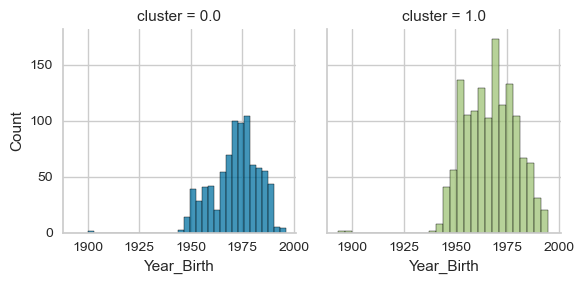

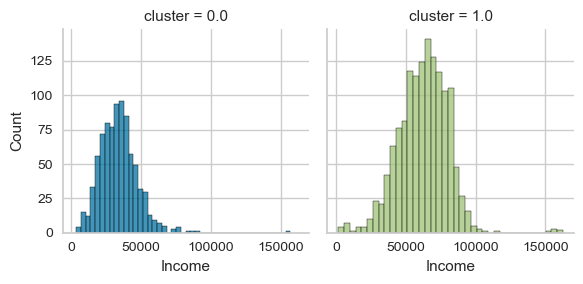

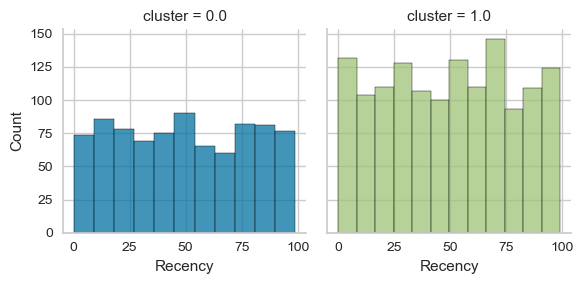

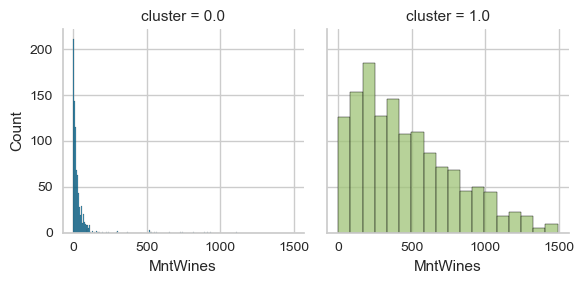

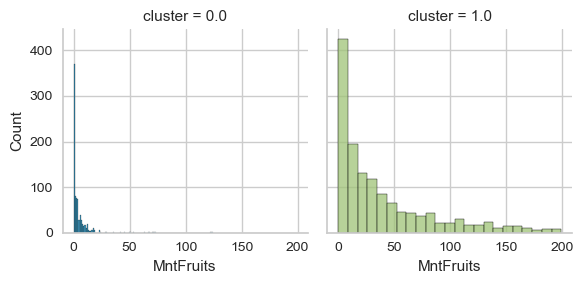

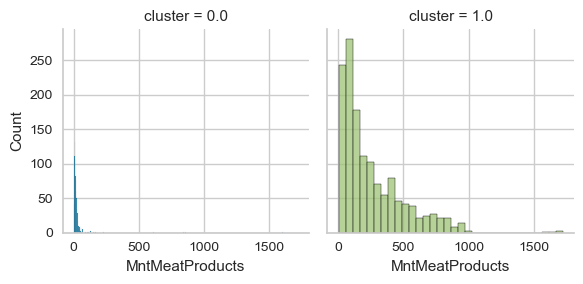

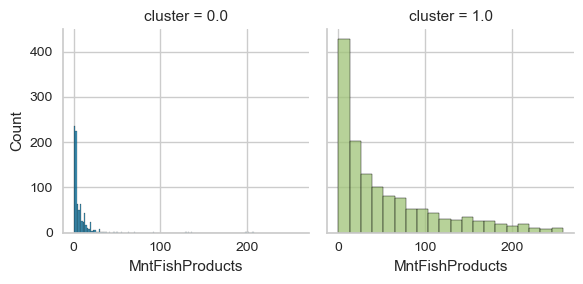

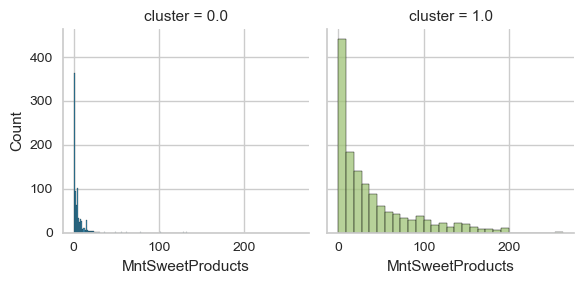

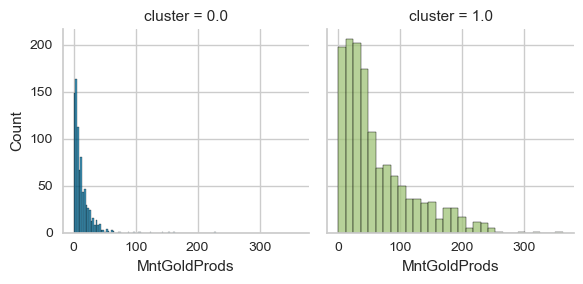

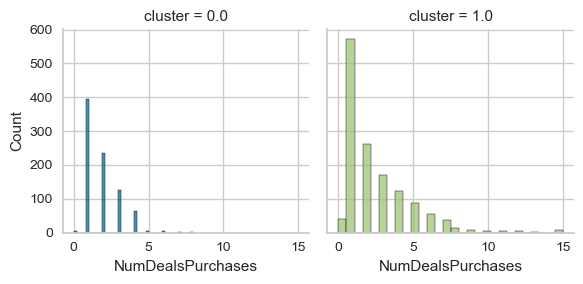

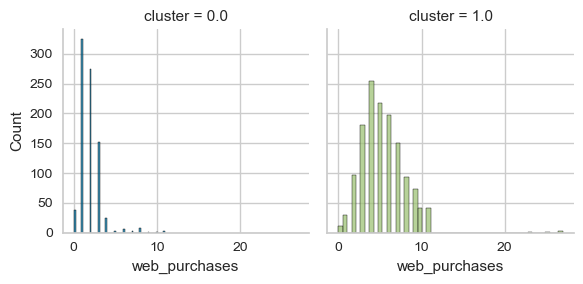

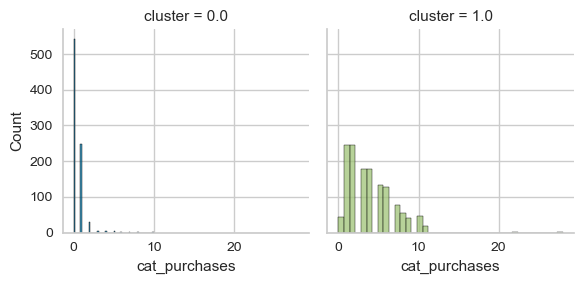

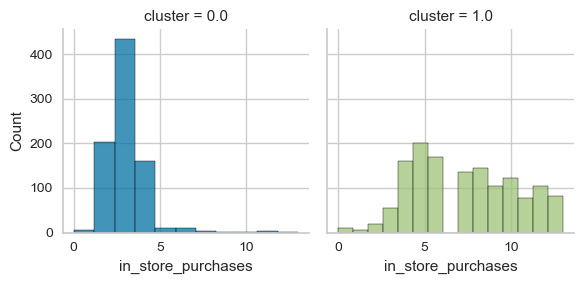

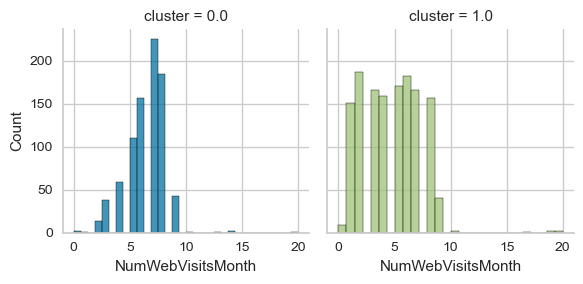

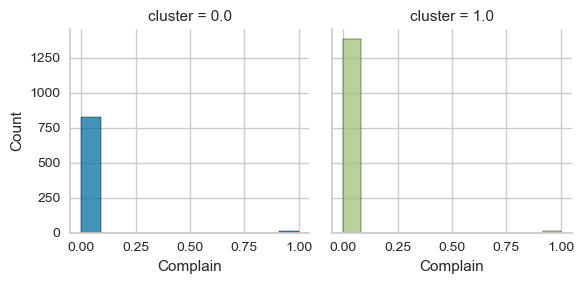

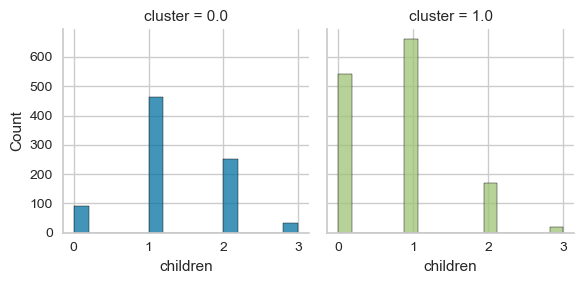

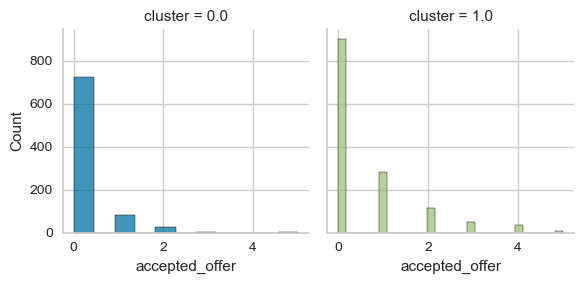

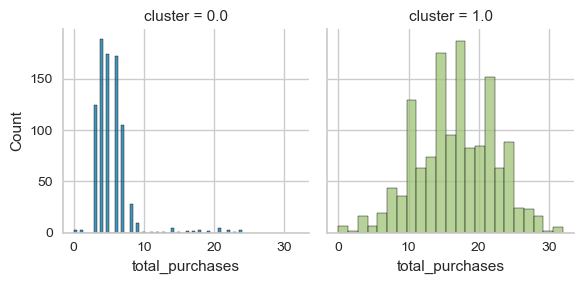

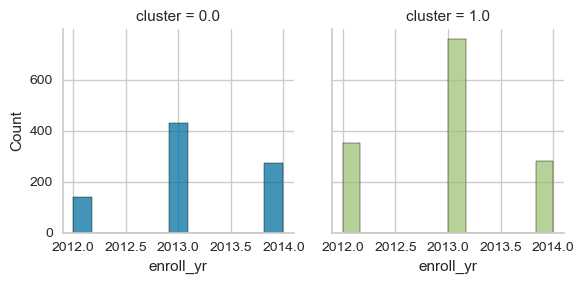

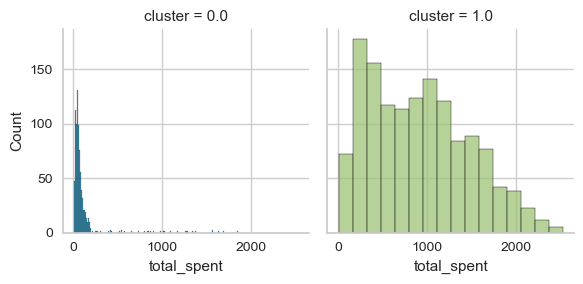

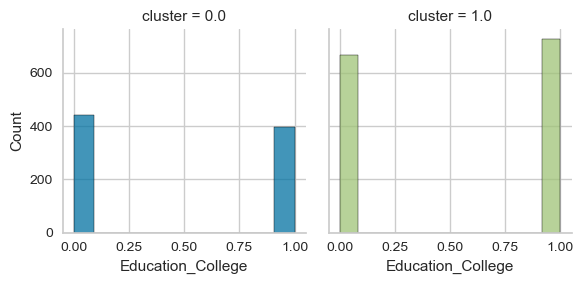

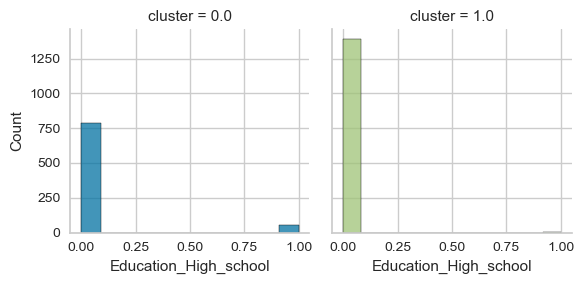

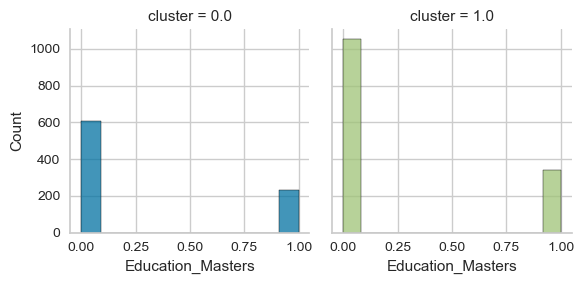

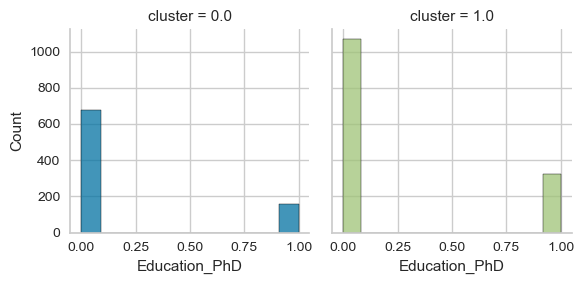

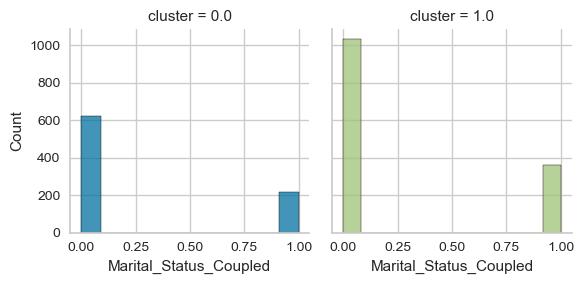

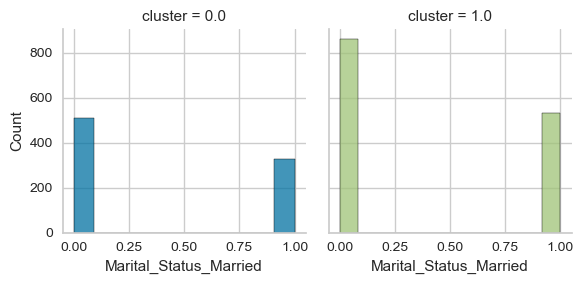

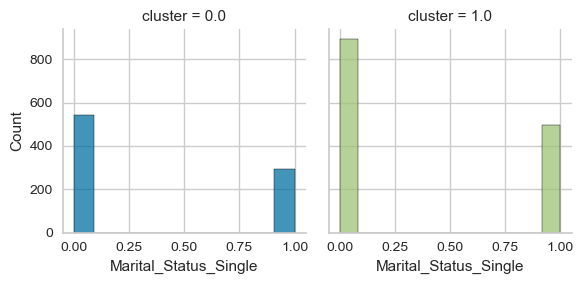

In [126]:
for i in df_clusters:
    if i == 'cluster':
        continue
    grid = sns.FacetGrid(df_clusters, col='cluster', hue='cluster')
    grid.map(sns.histplot, i)

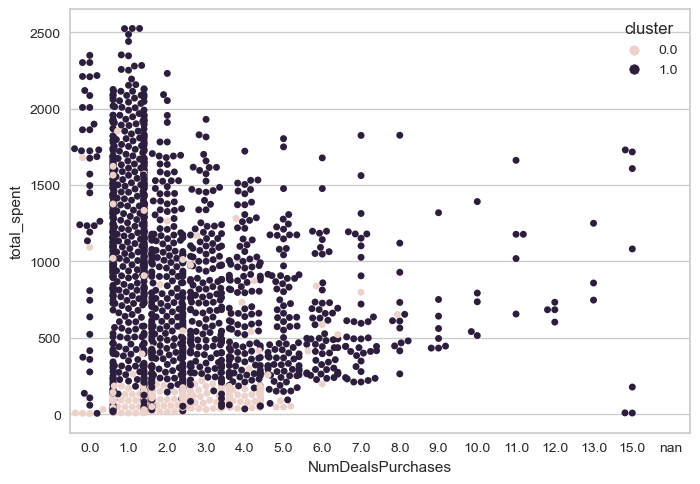

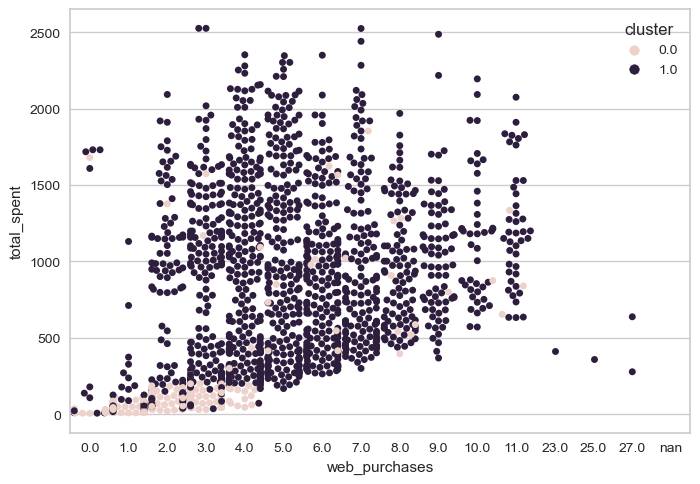

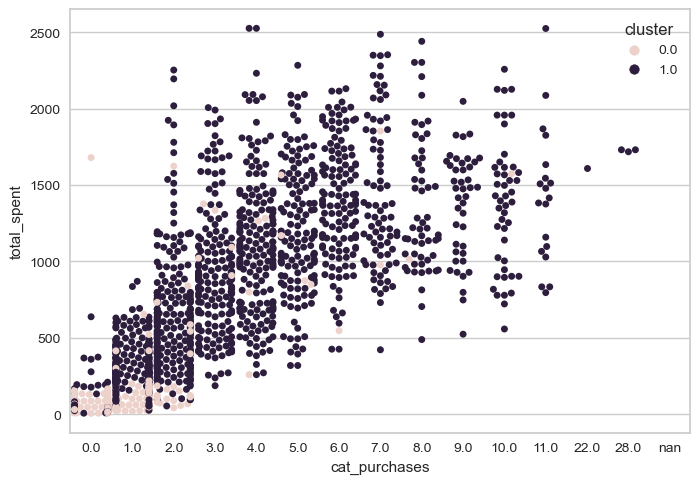

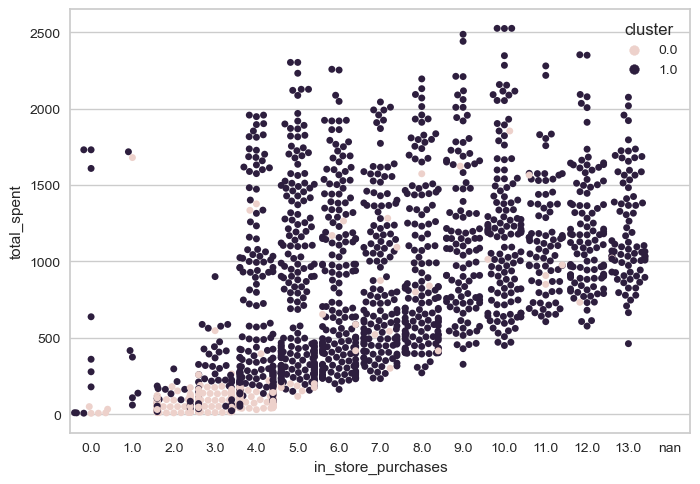

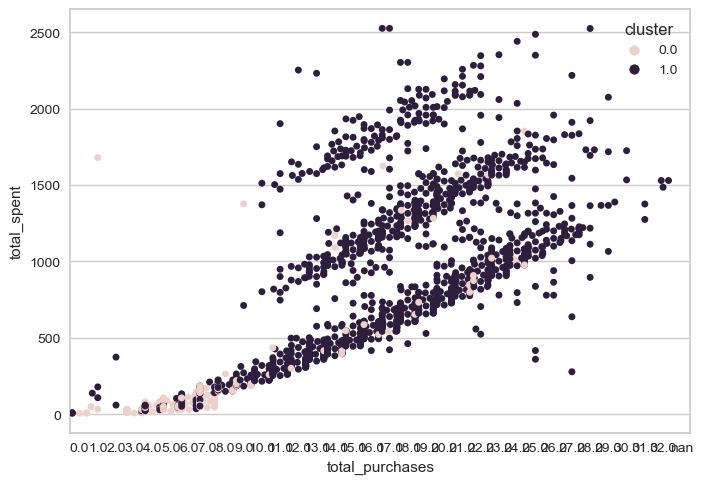

In [133]:
purchase_list = ['NumDealsPurchases', 'web_purchases', 'cat_purchases', 'in_store_purchases', 'total_purchases']
for j in purchase_list:
    plt.figure()
    sns.swarmplot(x=j, y='total_spent', hue='cluster', data=df_clusters)
    plt.show()

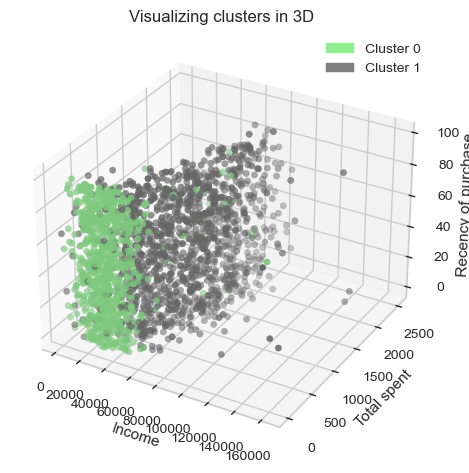

In [150]:
fig = plt.figure()
ax = plt.subplot(projection='3d')
ax.scatter(df_clusters['Income'], df_clusters['total_spent'], df_clusters['Recency'], c=df_clusters['cluster'], cmap='Accent')
pop_a = mpatches.Patch(color='lightgreen', label='Cluster 0') 
pop_b = mpatches.Patch(color='gray', label='Cluster 1') 
plt.legend(handles=[pop_a,pop_b])
plt.title('Visualizing clusters in 3D')
ax.set_xlabel('Income')
ax.set_ylabel('Total spent')
ax.set_zlabel('Recency of purchase')
plt.show()

## 5.3. Conclusions

### 5.3.1. Customer attributes by cluster

Cluster 0:  slightly lower income, lower recency, lower purchases of wine, fruit, meat, fish, sweets, gold, more likely to have a child, less purchases overall, less offers accepted, slightly less college grads, more high school grads, slightly more masters, more phds, more coupled, same married, slightly less single.

Cluster 1:  slightly higher income, higher purchases (by each type and total number), slightly less web visits each month, more offers accepted, more graduated from college, less coupled, more single.

### 5.3.2 Recommendations

#### For cluster 0:  the group that tends to purchase more items:

The company may want to target this group when they are having sales or are pushing any initiatives toward customers who are more reliable buyers.

#### For cluster 1:  the group that has thus-far been purchasing less items:  

The company may want to examine this group to see whether they can increase sales within this set of their customers.